In [2]:
# load swap data from csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
df = pd.read_csv('LQTYETH_swap.csv', index_col=0)


In [4]:
df['AMM_price'] = abs(df['amount_token0'] / df['amount_token1'])

df['abs_amount_token0'] = abs(df['amount_token0'])

df['weighted_price'] = df['AMM_price'] * df['abs_amount_token0']

# Group the dataframe by 'block_number' and aggregate the columns
grouped_df = df.groupby('block_number').agg({
    'amount_token0': 'sum',
    'abs_amount_token0': 'sum',
    'amount_token1': 'sum',
    'weighted_price': 'sum',
    'Price': 'mean',
}).reset_index()

# Calculate the weighted mean by dividing the sum of weighted prices by the sum of amount_token0
grouped_df['AMM_weighted_price'] = grouped_df['weighted_price'] / grouped_df['abs_amount_token0']

# Drop the temporary 'weighted_price' column
grouped_df = grouped_df.drop('weighted_price', axis=1)
grouped_df = grouped_df.drop('abs_amount_token0', axis=1)


In [8]:
grouped_df

,block_number,amount_token0,amount_token1,Price,AMM_weighted_price
0,16310758,2084.219188,-0.998042,2087.281594,2088.307923
1,16312217,22.570167,-0.010781,2087.490322,2093.519750
2,16312234,75.536808,-0.036077,2087.699071,2093.762456
3,16313105,-2009.976180,0.967988,2077.910396,2076.446506
4,16313401,161.977960,-0.077710,2078.533832,2084.385284
...,...,...,...,...,...
19291,17113430,3265.256565,-3.160734,1031.586372,1033.069191
19292,17152242,-4016.678407,3.921170,1025.723348,1024.357061
19293,17152243,-5338.584814,5.232134,1021.220304,1020.345587
19294,17152304,3411.151541,-3.325807,1024.083585,1025.661325


In [13]:
# get data from timestamps_blocktime
timestamps_blocktime = pd.read_csv('timestamps_blocktime2.csv')
# convert datetime to timestamp
timestamps_blocktime['timestamp'] = pd.to_datetime(timestamps_blocktime['timestamp']).astype(int) / 10**9
timestamps_blocktime['timestamp'] = timestamps_blocktime['timestamp'].astype(int)

In [14]:
block_data = grouped_df

def get_timestamp(block_number):
    if block_number in timestamps_blocktime['block_number'].values:
        return timestamps_blocktime[timestamps_blocktime['block_number'] == block_number]['timestamp'].values[0]
    else:
        return None
    
block_data['timestamp'] = block_data['block_number'].apply(get_timestamp)
block_data = block_data[block_data['block_number'] != 17195231]


In [72]:
block_data_sample = block_data[-1000:]
# create column called AMM_price where we divide amount_token0 by amount_token1
block_data_sample['AMM_price'] = abs(block_data_sample['amount_token0'] / block_data_sample['amount_token1'])

/var/folders/lv/l4xn1q3s7jxgwb_811k8vqrh0000gn/T/ipykernel_67873/1324829001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_data_sample['AMM_price'] = abs(block_data_sample['amount_token0'] / block_data_sample['amount_token1'])


In [73]:
# exclude last 30 items from the sample
block_data_sample = block_data_sample[:-30]

In [81]:
# include only items from block 16980000 onwards
block_data_sample = block_data_sample[block_data_sample['block_number'] >= 16980000]

In [83]:
# get start and end timestamps in swaps

start_timestamp = int(block_data_sample['timestamp'].min() * 1000)
end_timestamp = int(block_data_sample['timestamp'].max() * 1000)
print(start_timestamp, end_timestamp)

# convert the timestamps into datetime, singapore time
start_datetime = pd.to_datetime(start_timestamp, unit='ms') + pd.Timedelta(hours=8)
end_datetime = pd.to_datetime(end_timestamp, unit='ms') + pd.Timedelta(hours=8)

print(start_datetime, "to", end_datetime)

# get the difference between the two timestamps in hours
diff = (end_timestamp - start_timestamp) / 1000 / 60 / 60
print(diff,"hours")

1680666131000 1681072019000
2023-04-05 11:42:11 to 2023-04-10 04:26:59
112.74666666666667 hours


In [33]:
import requests
import random

# List of User-Agent strings to simulate different devices
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.81 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
]

# Helper function to get binance klines over a period longer than 1000 seconds
def get_binance_klines(symbol, startTime, endTime):
    url = "https://api.binance.com/api/v3/uiKlines"
    params = {
        "symbol": symbol,
        "interval": "1s",
        "startTime": startTime,
        "endTime": endTime,
        "limit": "1000"
    }

    data = []

    while True:
        # Randomly select a User-Agent from the list
        user_agent = random.choice(user_agents)
        
        headers = {
            "User-Agent": user_agent
        }
        
        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            batch_data = response.json()
            data.extend(batch_data)

            if len(batch_data) < 2:
                break

            # Update the startTime parameter for the next batch
            params["startTime"] = str(int(batch_data[-1][0]) + 1)
        else:
            print("Request failed with status code:", response.status_code)
            break

    return data


In [34]:
response = get_binance_klines("LQTYUSDT", start_timestamp, end_timestamp)
klines_data_LQTYUSDT = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000
klines_data_LQTYUSDT = klines_data_LQTYUSDT[['open_time', 'close_time', 'close']]
klines_data_LQTYUSDT['open_time'] = klines_data_LQTYUSDT['open_time'] / 1000
klines_data_LQTYUSDT['close_time'] = klines_data_LQTYUSDT['close_time'] / 1000

# convert open_time and close_time to int
klines_data_LQTYUSDT['open_time'] = klines_data_LQTYUSDT['open_time'].astype(int)
klines_data_LQTYUSDT['close_time'] = klines_data_LQTYUSDT['close_time'].astype(int)

klines_data_LQTYUSDT.to_csv(f'LQTYUSDT_klines_{start_timestamp}_{end_timestamp}.csv')

In [38]:
response = get_binance_klines("ETHUSDT", start_timestamp, end_timestamp)
klines_data_ETHUSDT = pd.DataFrame(response, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# create new datafram keeping only open_time, close_time, and close and divide open_time and close_time by 1000
klines_data_ETHUSDT = klines_data_ETHUSDT[['open_time', 'close_time', 'close']]
klines_data_ETHUSDT['open_time'] = klines_data_ETHUSDT['open_time'] / 1000
klines_data_ETHUSDT['close_time'] = klines_data_ETHUSDT['close_time'] / 1000

# convert open_time and close_time to int
klines_data_ETHUSDT['open_time'] = klines_data_ETHUSDT['open_time'].astype(int)
klines_data_ETHUSDT['close_time'] = klines_data_ETHUSDT['close_time'].astype(int)

klines_data_ETHUSDT.to_csv(f'ETHUSDT_klines_{start_timestamp}_{end_timestamp}.csv')

In [42]:
# combine the two data frames
klines_data = pd.merge(klines_data_LQTYUSDT, klines_data_ETHUSDT, on=['open_time', 'close_time'], how='inner')

In [46]:
# convert close_x and close_y to float
klines_data['close_x'] = klines_data['close_x'].astype(float)
klines_data['close_y'] = klines_data['close_y'].astype(float)

# create new column called close where close_y is multiplied by 1/close_x
klines_data['close'] = klines_data['close_y'] * (1 / klines_data['close_x'])

# drop close_x and close_y
klines_data = klines_data.drop(columns=['close_x', 'close_y'])
klines_data

,open_time,close_time,close
0,1680438347,1680438347,798.139023
1,1680438348,1680438348,798.134624
2,1680438349,1680438349,798.134624
3,1680438350,1680438350,798.139023
4,1680438351,1680438351,798.134624
...,...,...,...
2339648,1682777995,1682777995,1029.633423
2339649,1682777996,1682777996,1029.638814
2339650,1682777997,1682777997,1029.638814
2339651,1682777998,1682777998,1029.633423


In [89]:
block_data_sample

,block_number,amount_token0,amount_token1,Price,AMM_weighted_price,timestamp,AMM_price
18661,16980010,-20.918872,0.028631,732.871337,730.628656,1.680666e+09,730.628656
18662,16980013,-51.142677,0.070000,732.798057,730.609673,1.680666e+09,730.609673
18663,16980106,4149.941951,-5.637772,734.999642,736.096052,1.680667e+09,736.096052
18664,16980110,3514.336878,-4.761174,736.839348,738.124076,1.680667e+09,738.124076
18665,16980175,2996.937337,-4.050741,738.462097,739.849180,1.680668e+09,739.849180
...,...,...,...,...,...,...,...
19260,17012800,2085.389855,-2.474658,840.807961,842.698314,1.681069e+09,842.698314
19261,17012812,-3320.600000,3.965777,838.960309,837.313758,1.681069e+09,837.313758
19262,17012851,-4.600000,0.005500,838.960309,836.414899,1.681069e+09,836.414899
19263,17013054,55.008535,-0.065372,838.960309,841.469725,1.681072e+09,841.469725


In [84]:
# merge swaps and klines_data on timestamp and close_time
merged = pd.merge(block_data_sample, klines_data, left_on='timestamp', right_on='close_time')

# drop open_time and close_time and liquidity and tick and transaction_index and log_index
merged = merged.drop(columns=['open_time', 'close_time'])

merged['close'] = merged['close'].astype(float)

# Remove items where amount_token1 or amount_token0 is 0
merged = merged[merged['amount_token1'] != 0]
merged = merged[merged['amount_token0'] != 0]

# Create a column called action which is labelled either buy or sell depending on whether amount_token1 is positive or negative
merged['pool_action'] = np.where(merged['amount_token1'] > 0, 'buy', 'sell')

# Trader action is the opposite of pool action
merged['trader_action'] = np.where(merged['pool_action'] == 'buy', 'sell', 'buy')

# calculate LVR amount_token1*-1 * (close - AMM_price)
merged['LVR'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_price'])

# calculate LVR 2 amount_token1*-1 * (close - Price)
merged['LVR2'] = merged['amount_token1'] * -1 * (merged['close'] - merged['Price'])

# calculate LVR 3 amount_token1*-1 * (close - AMM_weighted_price)
merged['LVR3'] = merged['amount_token1'] * -1 * (merged['close'] - merged['AMM_weighted_price'])

# create a column for cumulative LVR sum
merged['cum_LVR'] = merged['LVR'].cumsum()

# create a column for cumulative LVR2 sum
merged['cum_LVR2'] = merged['LVR2'].cumsum()

# create a column for cumulative LVR3 sum
merged['cum_LVR3'] = merged['LVR3'].cumsum()

# order the columns in this order timestamp, block_numner, transaction_index, price, amm_price, close, pool_action, trader_action, LVR, cum_LVR
merged = merged[['timestamp', 'block_number', 'Price', 'AMM_price','AMM_weighted_price' ,'close', 'amount_token0', 'amount_token1','pool_action', 'trader_action', 'LVR', 'LVR2','LVR3','cum_LVR','cum_LVR2', 'cum_LVR3']]

# rename close to Close_price
merged = merged.rename(columns={'close': 'Close_price'})


# remove items where amount_token0 is less than 0.001
# merged = merged[abs(merged['amount_token1']) > 0.001]

In [85]:
# get last 3 items
merged.tail(10)

,timestamp,block_number,Price,AMM_price,AMM_weighted_price,Close_price,amount_token0,amount_token1,pool_action,trader_action,LVR,LVR2,LVR3,cum_LVR,cum_LVR2,cum_LVR3
594,1.681050e+09,17011306,848.578696,848.978477,848.978477,848.312471,7829.904604,-9.222736,sell,buy,-6.142395,-2.455322,-6.142395,2116.575332,4524.699905,2238.210123
595,1.681051e+09,17011350,844.346603,843.901415,843.901415,842.811781,-7772.690617,9.210425,buy,sell,10.035994,14.136364,10.035994,2126.611326,4538.836269,2248.246117
596,1.681066e+09,17012560,842.743948,840.975222,840.975222,838.688525,-3017.700000,3.588334,buy,sell,8.205434,14.552213,8.205434,2134.816760,4553.388482,2256.451552
597,1.681066e+09,17012573,841.228449,839.407806,839.407806,836.663640,-2767.800000,3.297325,buy,sell,9.048404,15.051654,9.048404,2143.865165,4568.440136,2265.499956
598,1.681066e+09,17012597,839.631712,837.872670,837.872670,835.886621,-2903.613943,3.465460,buy,sell,6.882570,12.978460,6.882570,2150.747735,4581.418596,2272.382526
599,1.681069e+09,17012800,840.807961,842.698314,842.698314,835.975774,2085.389855,-2.474658,sell,buy,-16.635986,-11.958008,-16.635986,2134.111748,4569.460588,2255.746540
600,1.681069e+09,17012812,838.960309,837.313758,837.313758,834.052844,-3320.600000,3.965777,buy,sell,12.932062,19.461914,12.932062,2147.043811,4588.922502,2268.678602
601,1.681069e+09,17012851,838.960309,836.414899,836.414899,834.993252,-4.600000,0.005500,buy,sell,0.007819,0.021817,0.007819,2147.051629,4588.944319,2268.686420
602,1.681072e+09,17013054,838.960309,841.469725,841.469725,840.916100,55.008535,-0.065372,sell,buy,-0.036192,0.127854,-0.036192,2147.015438,4589.072173,2268.650229
603,1.681072e+09,17013077,840.555769,842.277237,842.277237,843.627674,2923.250327,-3.470651,sell,buy,4.686897,10.661512,4.686897,2151.702335,4599.733685,2273.337126


## Using Price from Net Trade

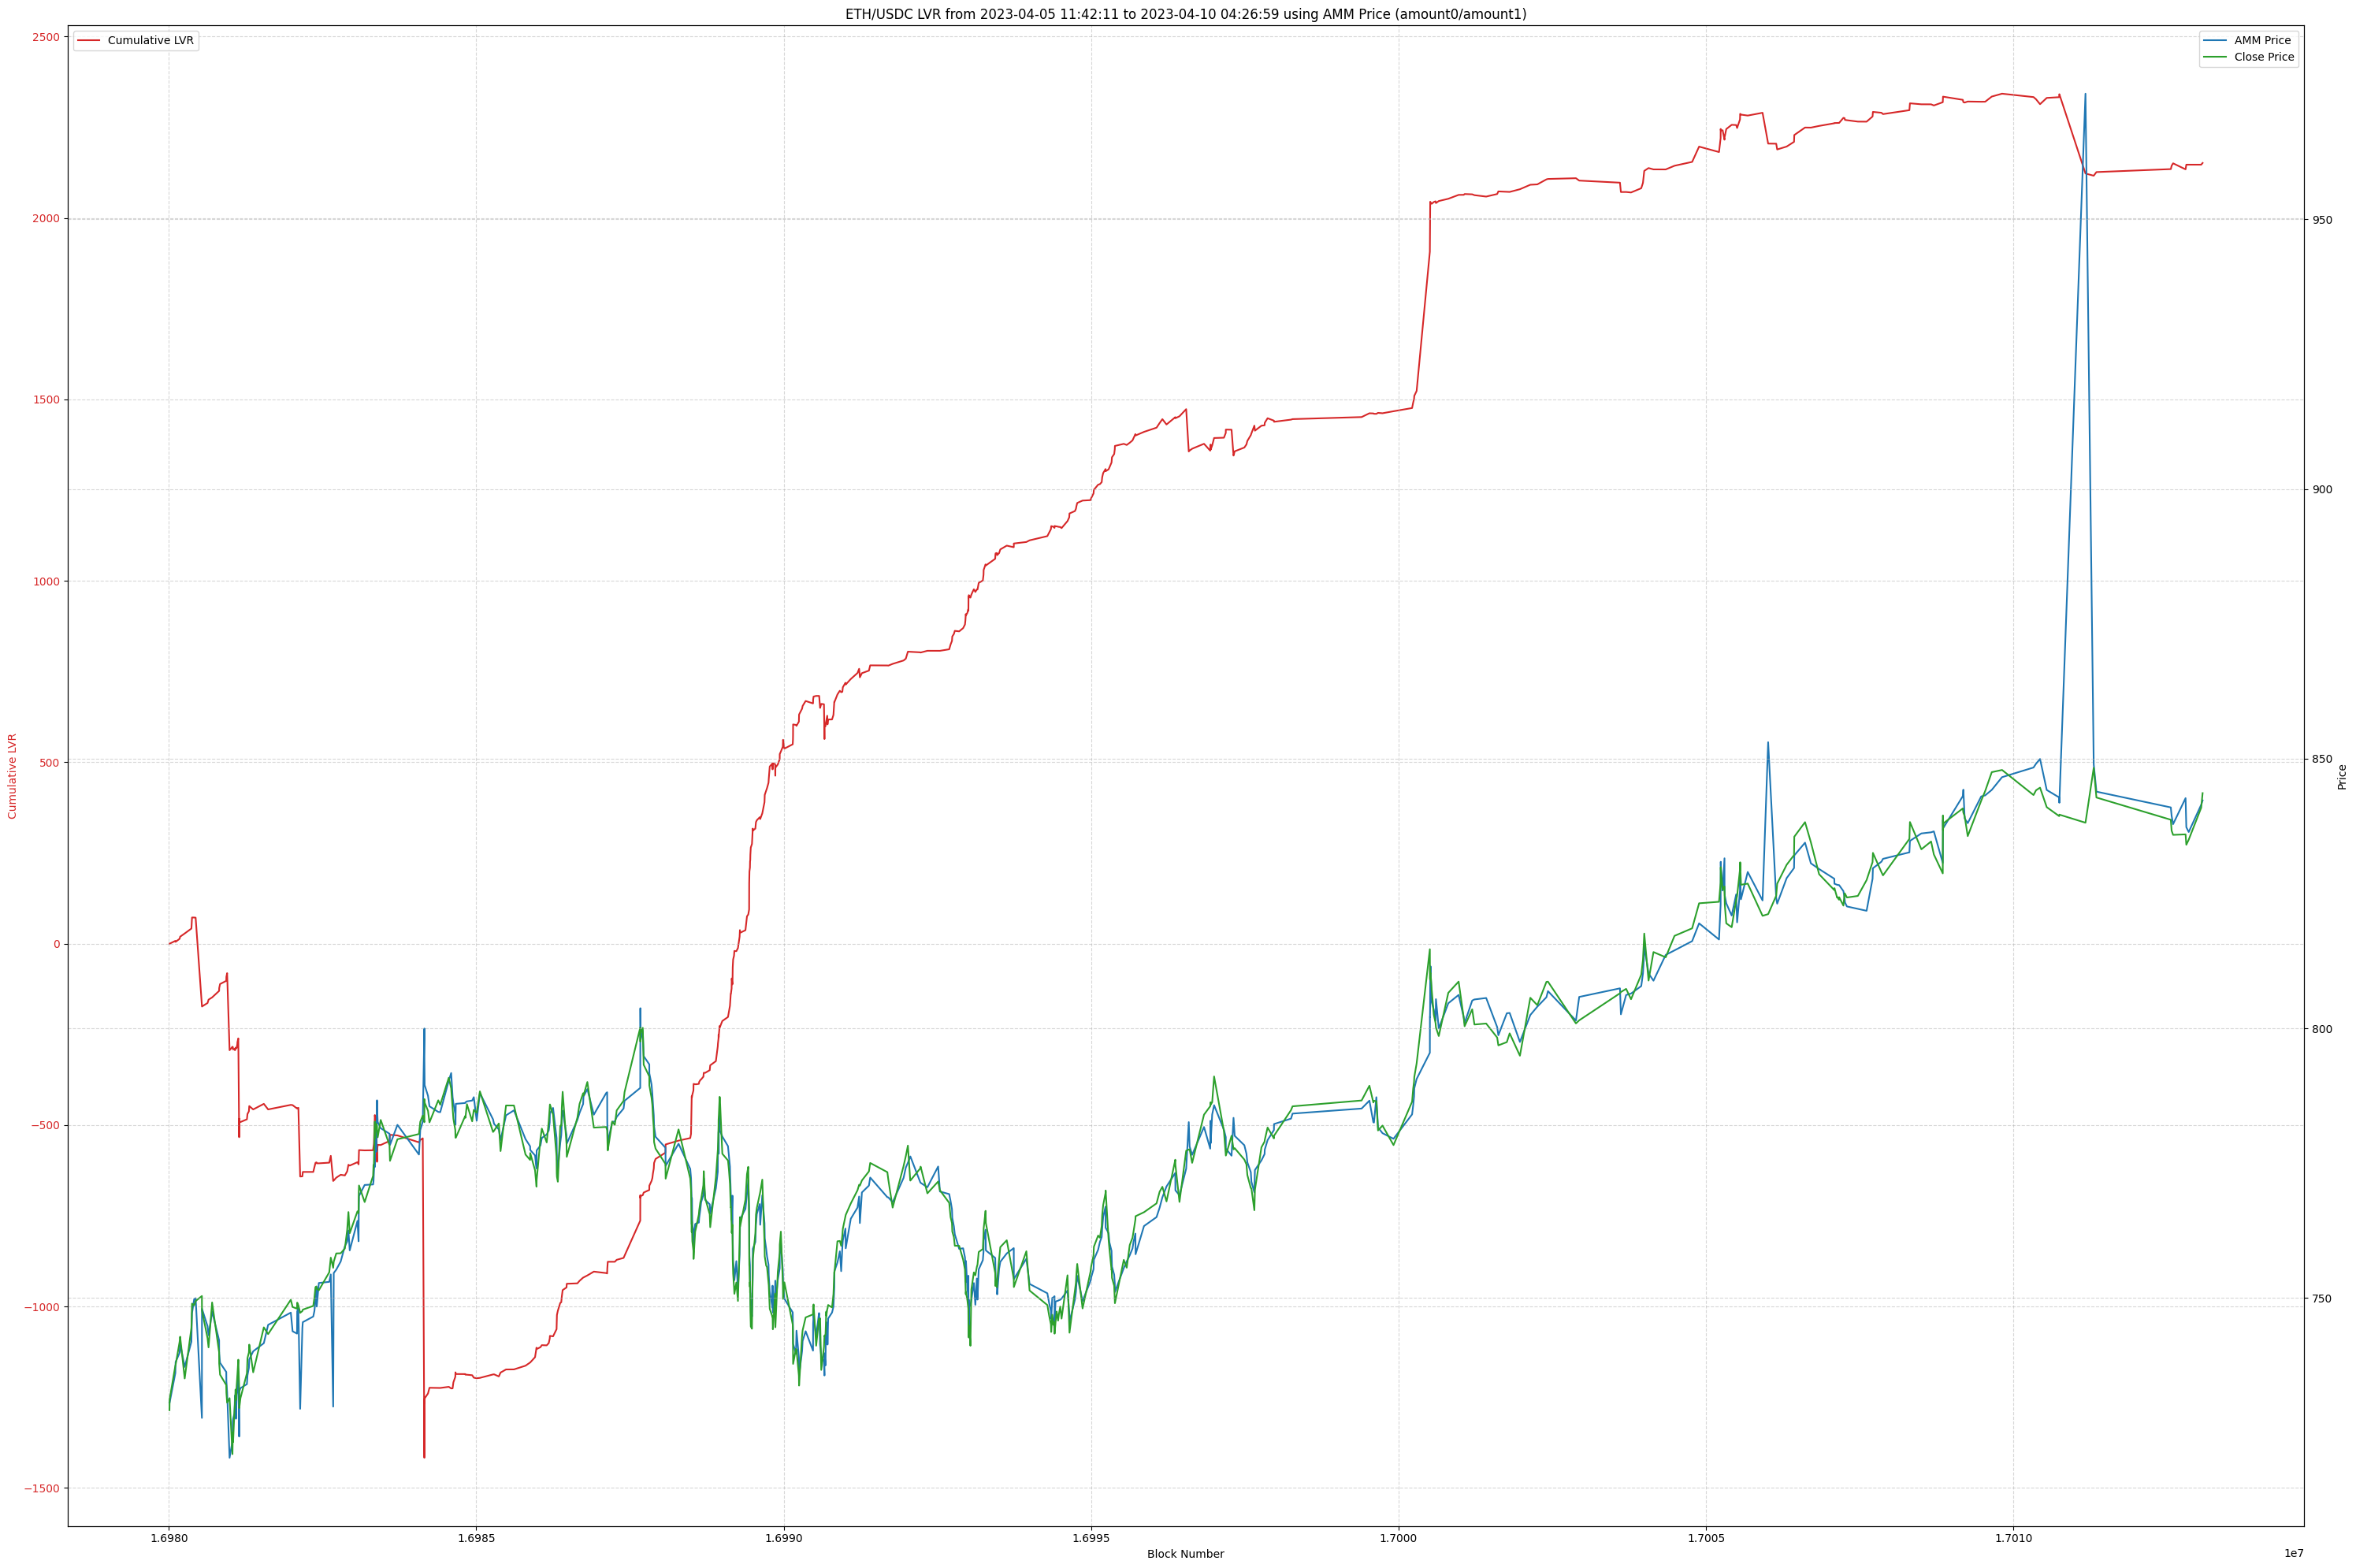

In [86]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR'], color=color1, label='Cumulative LVR', zorder=1)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['AMM_price'], color=color2, label='AMM Price', zorder=1)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=1)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using AMM Price (amount0/amount1)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR'].iloc[i] - merged['cum_LVR'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [90]:
merged['cum_LVR'].iloc[-1]

2151.7023348059647

## Using Price from Tick

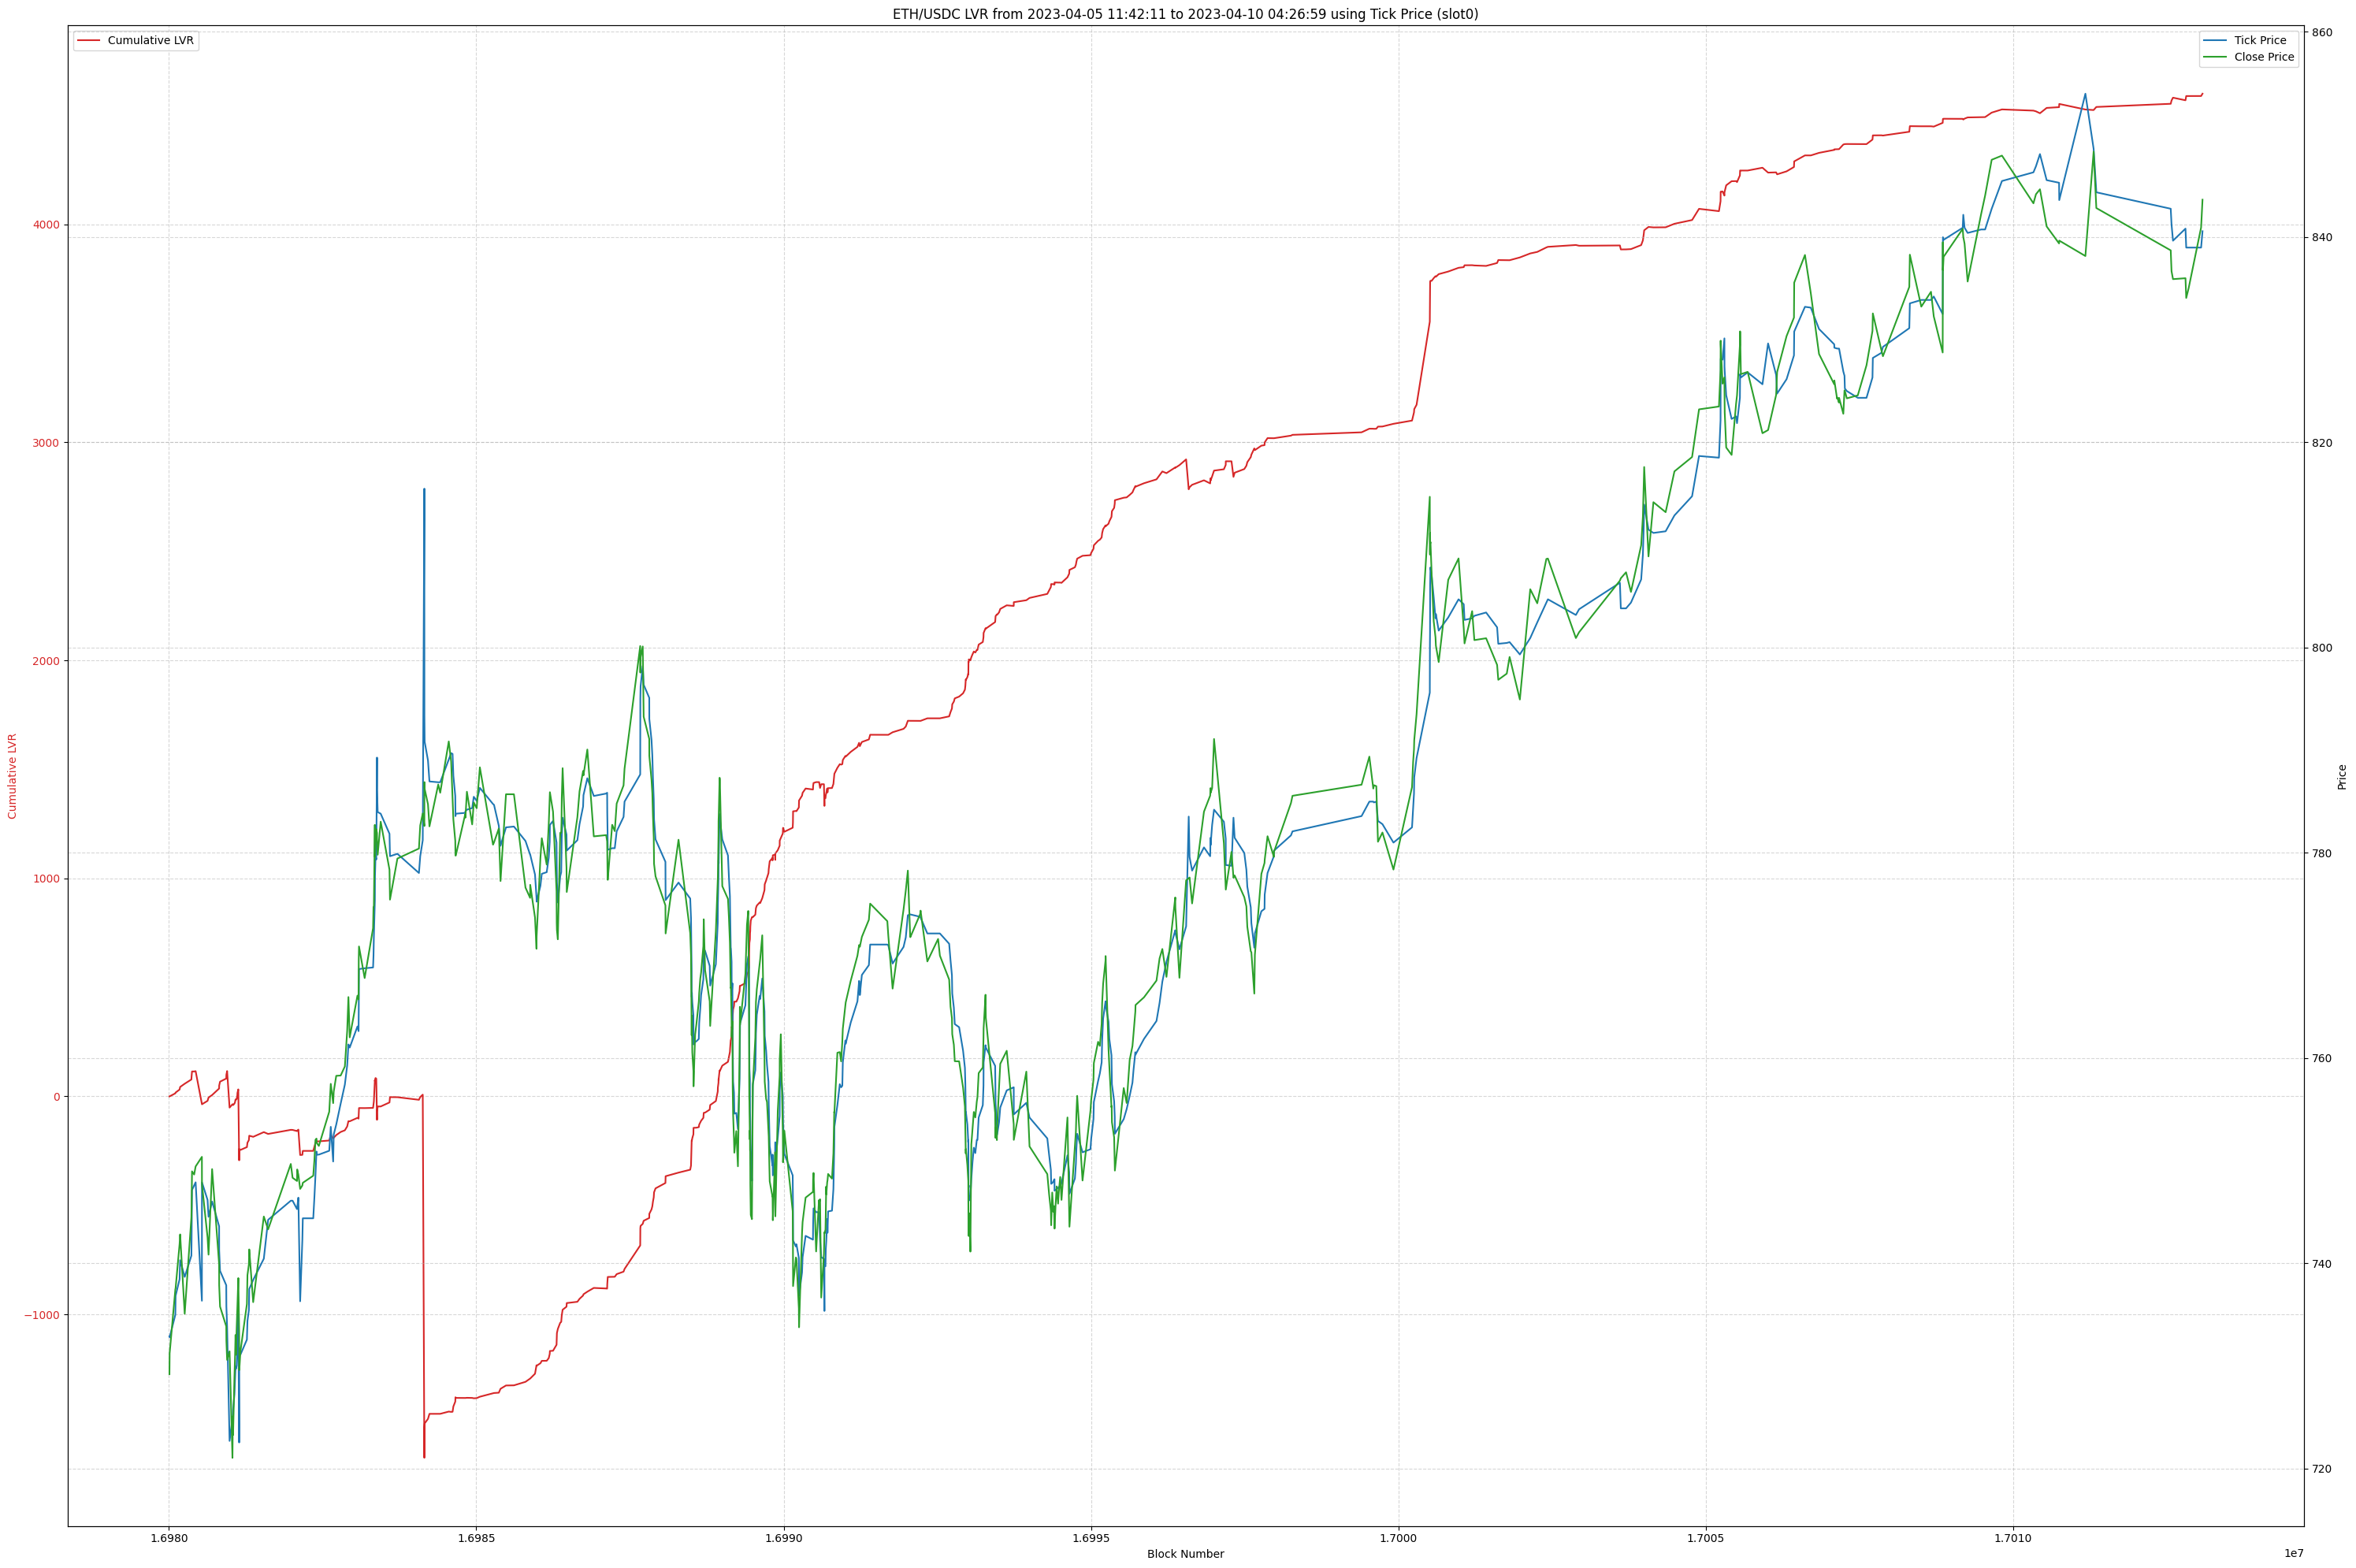

In [87]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR2'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['Price'], color=color2, label='Tick Price', zorder=3)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR2'].iloc[i] - merged['cum_LVR2'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR2'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR2'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [91]:
merged['cum_LVR2'].iloc[-1]

4599.73368486096

## Using Weighted Average Price across the Block

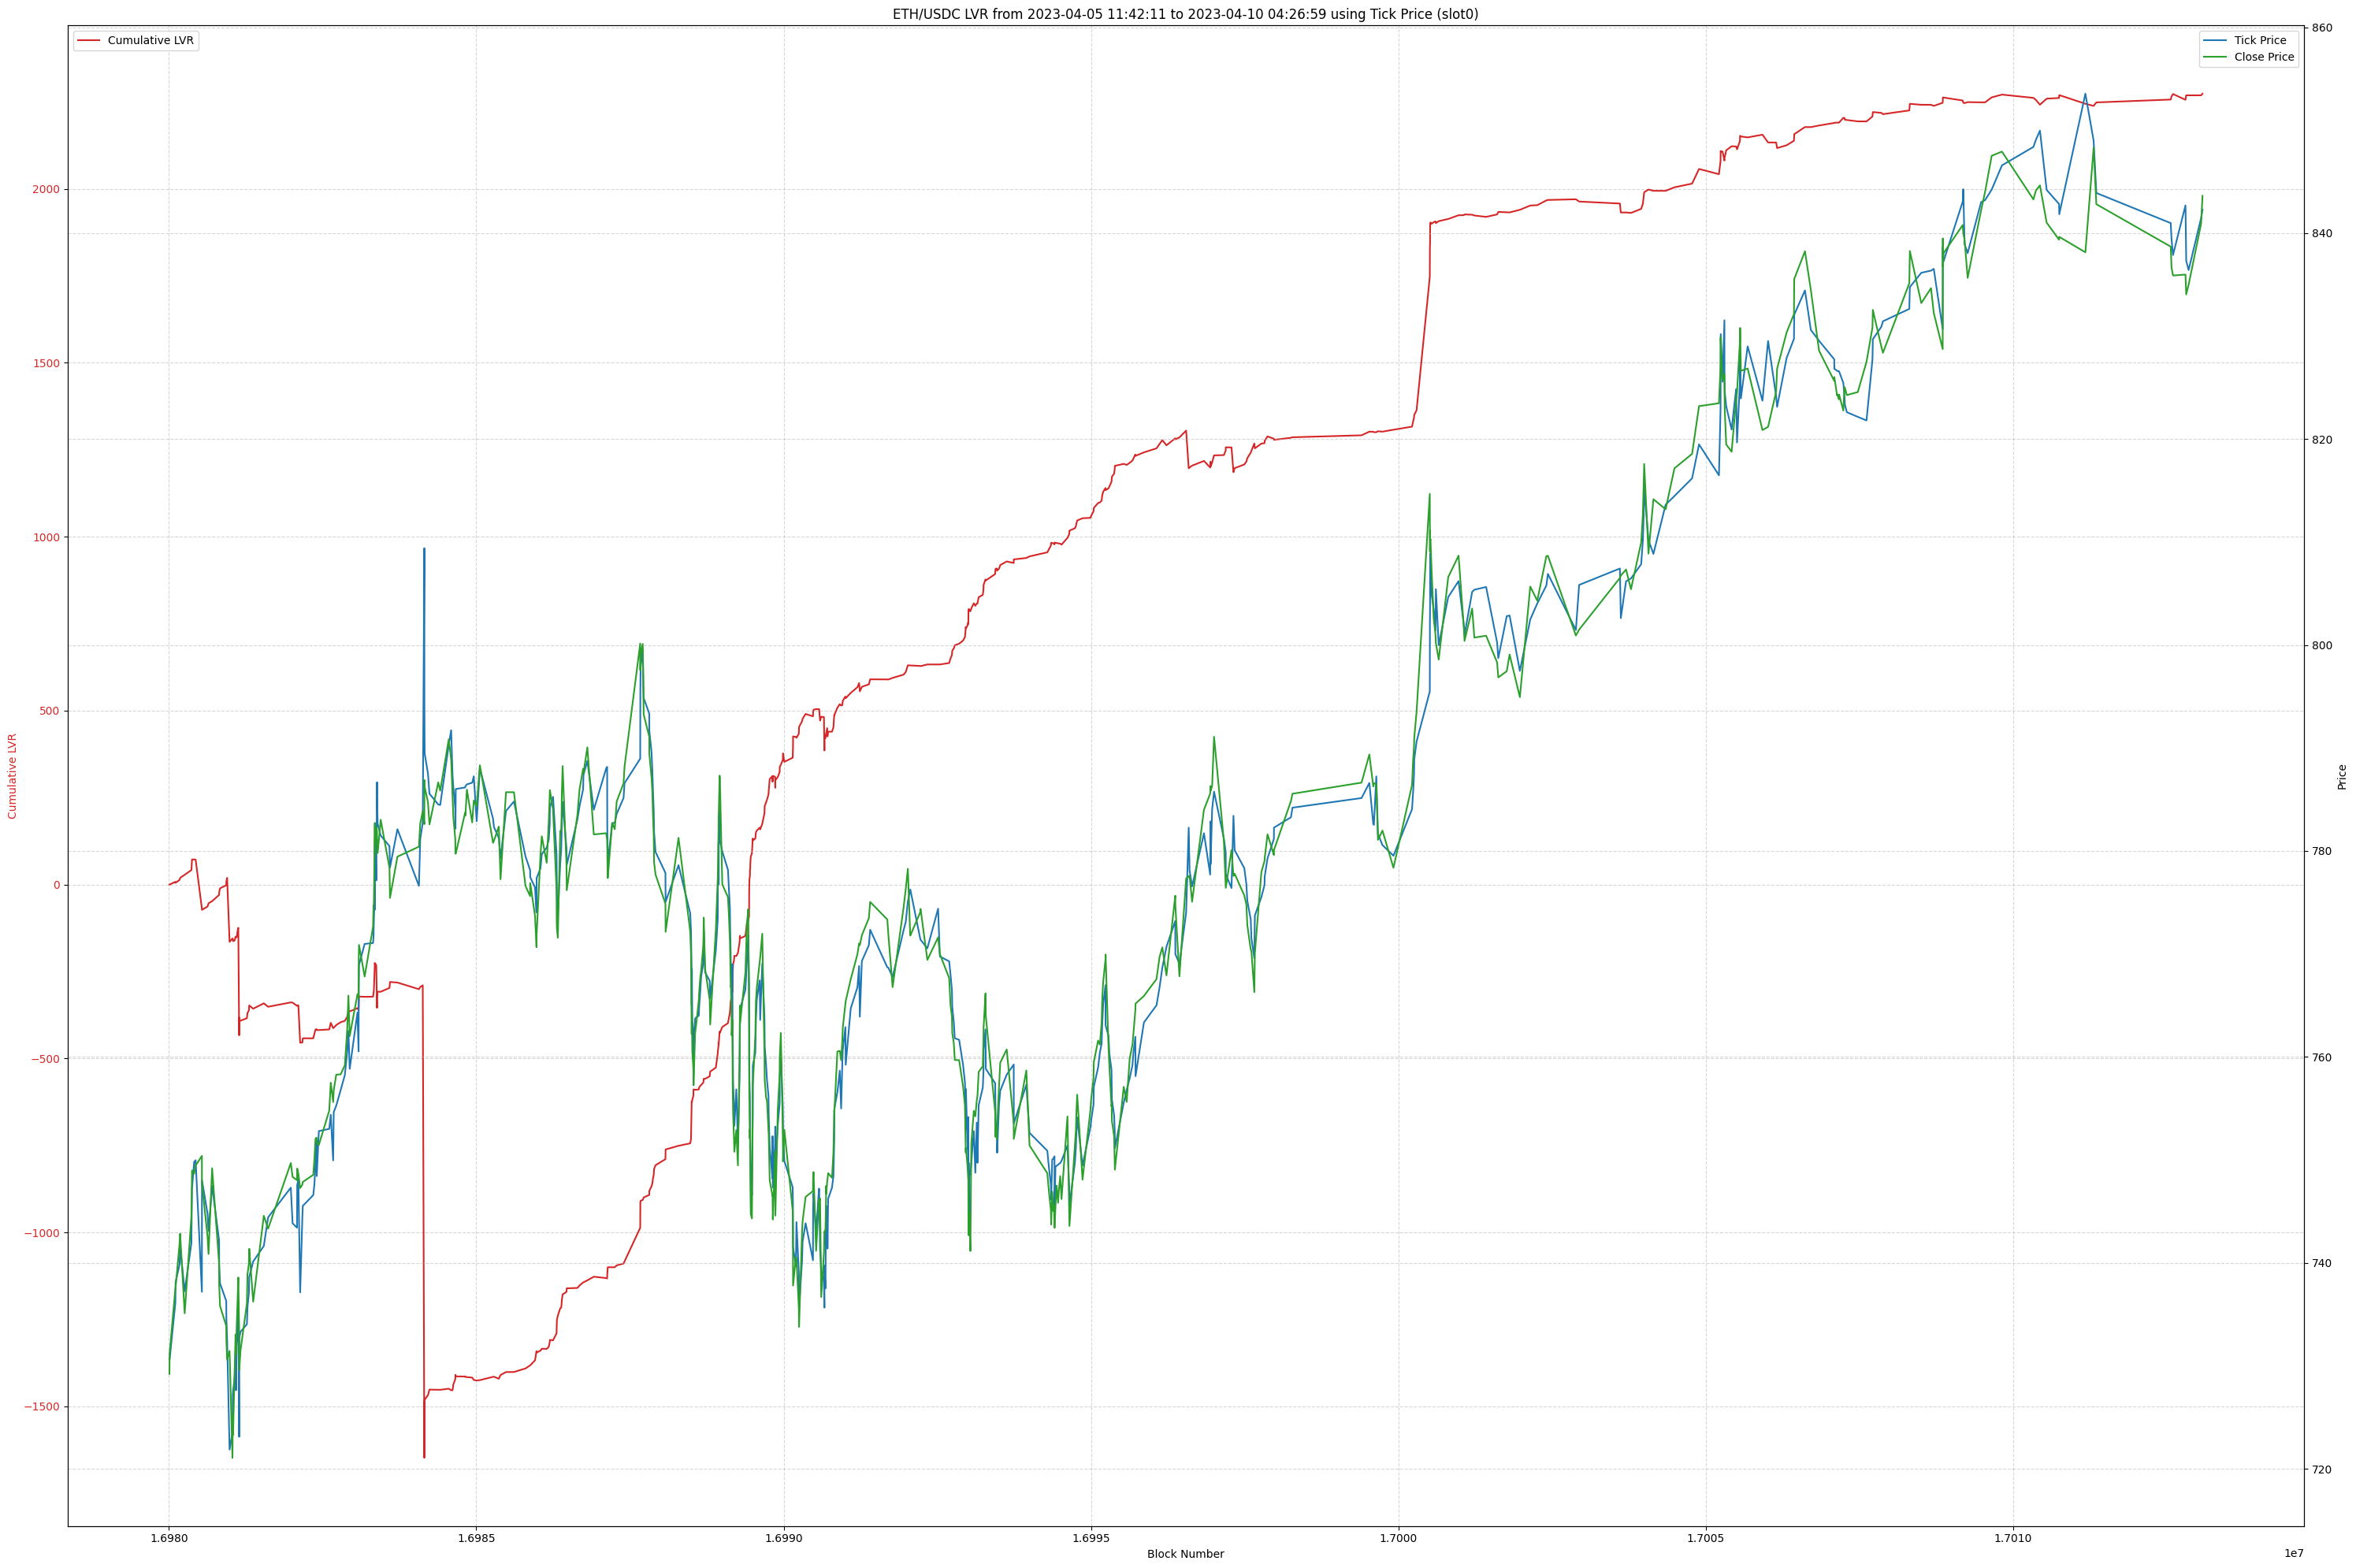

In [88]:
import matplotlib.pyplot as plt

# Increase figure size
fig, ax1 = plt.subplots(figsize=(30, 20))

# Set colors for the lines
color1 = 'tab:red'
color2 = 'tab:blue'
color3 = 'tab:green'

# Plot the data
ax1.plot(merged['block_number'], merged['cum_LVR3'], color=color1, label='Cumulative LVR', zorder=2)
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Cumulative LVR', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged['block_number'], merged['AMM_weighted_price'], color=color2, label='Tick Price', zorder=3)
ax2.plot(merged['block_number'], merged['Close_price'], color=color3, label='Close Price', zorder=3)
ax2.set_ylabel('Price', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set grid lines
ax1.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.grid(True, linestyle='--', alpha=0.5, zorder=0)

# Set legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Get timestamp from first and last item
first_timestamp = merged['timestamp'].iloc[0]
last_timestamp = merged['timestamp'].iloc[-1]

# convert timestamp to datetim
first_timestamp = pd.to_datetime(first_timestamp, unit='s') + pd.Timedelta(hours=8)
last_timestamp = pd.to_datetime(last_timestamp, unit='s') + pd.Timedelta(hours=8)

# Set title and include time period
plt.title(f'ETH/USDC LVR from {first_timestamp} to {last_timestamp} using Tick Price (slot0)')

# Annotate drastic LVR changes
threshold_change = 10000  # Define the threshold percentage for a drastic change (adjust as needed)

for i in range(1, len(merged)):
    lvr_change = abs(merged['cum_LVR3'].iloc[i] - merged['cum_LVR3'].iloc[i-1])
    if lvr_change > threshold_change:
        annotation_text = f"Block: {merged['block_number'].iloc[i]:.2f} Close Price: {merged['Close_price'].iloc[i]:.2f}  AMM Price: {merged['AMM_price'].iloc[i]:.2f} USDC Moved: {merged['amount_token0'].iloc[i]:.2f} ETH Moved: {merged['amount_token1'].iloc[i]:.2f} Pool Action: {merged['pool_action'].iloc[i]}  LVR: {merged['LVR3'].iloc[i]:.2f}"
        ax1.plot(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i], 'ro', zorder=2)  # Add a red dot marker
        color = ''
        if merged['LVR'].iloc[i] > 0:
            color = 'green'
        else:
            color = 'red'

        ax1.annotate(annotation_text, xy=(merged['block_number'].iloc[i], merged['cum_LVR3'].iloc[i]),
                     xytext=(5, 15), textcoords='offset points', color=color, ha='left', zorder=3)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.show()


In [92]:
merged['cum_LVR3'].iloc[-1]

2273.3371260812537